In [14]:
import os
import numpy as np
import pandas as pd

# to later draw the tree
import graphviz 
from sklearn import tree

# Machine learning algorithms
from sklearn.ensemble import RandomForestRegressor #Random Forest

# Cross-validation
'''
GridSearchCV = Perform an optimization of the parameters. 可以保证在指定的参数范围内找到精度最高的参数
                1. search for the best parameters for model; 
                2. automatically fit a new model on the training dataset w/ the parameters that 
                    can yield the best cross-validation performance.
cross_val_score = to implement cross-validation in scikit-learn.
PS: When an integer is passed to the cv parameter of cross_val_score():
        cv=int (same as cv=StratifiedKFold(n_splits=int)) is used if the estimator is a classifier 
        and y is either binary or multiclass; In all other cases, KFold is used.
        i.e. 写int=10会自动转换为KFold(n_splits=10),不会转换为StratifiedKFold(n_splits=10)。
'''
from sklearn.model_selection import GridSearchCV, cross_val_score

path = os.getcwd()#get current path
path_up1Dir = os.path.dirname(path)#go up one directory
dataset = pd.read_excel(path_up1Dir +'/y_MVPA/y_MVPA.xlsx')#to import the preprocessed dataset into a variable

# print(dataset)

In [15]:
X = pd.DataFrame(dataset.iloc[:,5:10])
y = dataset['aveTotalArea']
other = pd.DataFrame(dataset.iloc[:,:4])
# print(X, y, other)

In [16]:
# Random Forest
'''
Why RandomForestRegressor not RandomForestClassifier?
    - first, there is a huge difference between classifiers and regressors. 
        Classifiers predict a set of specified labels. 
            e.g. Email Spam Detection, where to classify whether an email is either spam (1) or not spam(0) . 
        Regressors predict some value, which could be almost anything. 
            (predict real valued outputs which vary and dont require outputs predicted to be in a fixed set)
            e.g. Predicting the runs scored by a team in a cricket match.
    - in our case, we want to use data to predict MVPA_minutes.week from any of the four Total Area (cm²) average scores.
    - so, we are predicting a quantity instead of a label, which means we should use regressor.
'''

'''
The main parameters to adjust when using these methods is n_estimators and max_features.
In order to reduce the size of the model, you can change these parameters: 
    min_samples_split, max_leaf_nodes, max_depth and min_samples_leaf.
# n_estimators = the number of trees in the forest. 
                The larger the better, but also the longer it takes to compute.
# max_features = the number of features that are selected, aka how random each tree is.
                The lower the greater the reduction of variance, but also the greater the increase in bias.
                range = (0,1]
# max_depth = 可以生成多少层叶子, to reduce the complexity of each tree to prevent overfitting, often not deeper than five splits
# min_samples_split = 限制了子树继续划分的条件，如果某节点的样本数少于min_samples_split，则不会继续再尝试选择最优特征来进行划分。
# bootstrap = True: 使用自助采样法; False: 使用整个数据集.
'''

# Set param_grid, aka the main parameters in RandomForestRegressor
param_grid_RandomForestRegressor = {
    'n_estimators':np.arange(10,101,10), # 从10到100，每隔10取一个
    'max_features':np.arange(0.1,1.1,0.1), # 从0.1到1，每隔0.1取一个
    'max_depth':np.arange(1,11),
    #'min_samples_split':np.arange(2,10),
    'bootstrap':[True,False]
}

# GridSearchCV
rfg = GridSearchCV(estimator=RandomForestRegressor(), # algorithm - Random Forest Regressor
                    param_grid=param_grid_RandomForestRegressor, # specify the parameters to search over using a dict or list of dictionaries
                    cv=10, # 10-Fold
                    scoring='r2'
                    )

# Build the model, aka training the dataset
rfg.fit(X, y.values.ravel())

# Output the best parameter, cross-validation score, estimator, and the index of best estimator.
print("\n------------------ RandomForestRegressor Model")
print("Best parameter: {}".format(rfg.best_params_))
print("Best score in r2: {:.2f}".format(rfg.best_score_))
print("Average score in 10-Fold: \n", rfg.cv_results_['mean_test_score'])
print("Std score in 10-Fold: \n", rfg.cv_results_['std_test_score'])
print("Best estimator: {}".format(rfg.best_estimator_))
print("The Index of Best estimator: {}".format(rfg.best_index_))


------------------ RandomForestRegressor Model
Best parameter: {'bootstrap': True, 'max_depth': 6, 'max_features': 0.5, 'n_estimators': 80}
Best score in r2: 0.76
Average score in 10-Fold: 
 [0.42876236 0.42863346 0.46651942 ... 0.62686144 0.62660863 0.62590342]
Std score in 10-Fold: 
 [0.11153871 0.09151419 0.09445947 ... 0.13262082 0.13224437 0.13193655]
Best estimator: RandomForestRegressor(max_depth=6, max_features=0.5, n_estimators=80)
The Index of Best estimator: 547


In [5]:
'''
机器学习不同于统计建模，有些定义不一样。sklearn这个包定义的比较奇怪而已。
https://zhuanlan.zhihu.com/p/369330147，score接近于1越好的是R2这个指标，其他的指标是接近于0越好。把负数去掉即可。
'''
# 10-Fold Cross-validation to check its accuracy again
score = cross_val_score(estimator=RandomForestRegressor(max_depth=1, max_features=0.1, n_estimators=20),
                        X=X, y=y.values.ravel(),
                        cv=10
                       )
print(score)

[-0.01344671 -0.95940859 -0.23637083 -0.27175228 -0.36498477 -0.13736652
 -0.0516818  -0.00601888  0.01583261 -0.03433296]


In [6]:
# Use the above optimal parameters to build new model, aka training the dataset
rfg = RandomForestRegressor(max_depth=1, max_features=0.1, n_estimators=20).fit(X, y.values.ravel())

In [7]:
yhat = rfg.predict(X)
print("Test set predictions:\n {}".format(yhat))

Test set predictions:
 [-1.42204118e-04 -2.55128489e-02 -1.74509963e-02 -2.56581024e-02
 -2.55128489e-02 -5.38523299e-02 -2.56581024e-02 -2.56581024e-02
 -1.74509963e-02 -1.74509963e-02 -2.56581024e-02  4.70964150e-02
 -2.56581024e-02  7.51157010e-02  7.51157010e-02 -2.56581024e-02
  5.33910845e-02 -2.56581024e-02  5.81373590e-03  2.38572717e-01
 -2.56581024e-02  4.70964150e-02 -1.28084501e-02 -6.85251008e-03
 -2.15276966e-02  3.44301690e-02 -2.15276966e-02 -2.56581024e-02
 -3.83243484e-02 -6.85251008e-03 -2.56581024e-02 -1.74509963e-02
 -6.19306527e-03 -1.42204118e-04 -2.56581024e-02 -2.56581024e-02
 -2.55128489e-02 -3.83243484e-02  9.39825374e-03 -3.83243484e-02
 -1.74509963e-02  3.44301690e-02 -1.74509963e-02 -3.83243484e-02
  3.44301690e-02  3.01263523e-02 -2.15276966e-02 -3.83243484e-02
 -3.83243484e-02  3.44301690e-02  3.44301690e-02 -2.56581024e-02
  3.44301690e-02 -3.83243484e-02  7.51157010e-02  4.70964150e-02
 -3.83243484e-02 -1.74509963e-02 -2.56581024e-02 -3.83243484e-02
 -

In [8]:
from sklearn.metrics import mean_squared_error as MSE
MSE(y_true=y, y_pred=yhat)

0.9797824547593199

In [9]:
#调用R2
from sklearn.metrics import r2_score
r2_score(yhat,y)

-385.07071807153244

In [10]:
r2 = rfg.score(X,y)
r2

0.02021754524068009

In [11]:
r2_score(y_true = y, y_pred = yhat)

0.02021754524068009

In [12]:
cross_val_score(rfg,X,y.values.ravel(),cv=10,scoring="r2").mean()

-0.20916837840938846

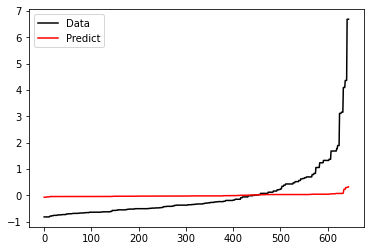

In [13]:
import matplotlib.pyplot as plt
y = dataset['MVPA']
sorted(y)
plt.plot(range(len(y)),sorted(y),c="black",label= "Data")
plt.plot(range(len(yhat)),sorted(yhat),c="red",label = "Predict")
plt.legend()
plt.show()

In [7]:
# Draw the Random Forest
rfg_tree = rfg.estimators_[0] # Draw the first tree

# Export a decision tree w/ color in DOT format.
dot_data = tree.export_graphviz(decision_tree=rfg_tree, # decision tree classifier
                               filled=True, # True: paint nodes to indicate majority class for classification, extremity of values for regression, or purity of node for multi-output
                               rounded=True, # True: draw node boxes with rounded corners and use Helvetica fonts instead of Times-Roman
                               special_characters=True # True: do not ignore special characters for PostScript compatibility
                               )

# Output the graph
graph = graphviz.Source(dot_data)
graph.render(filename='x_TotalArea_y_MVPA_RandomForest1', 
            directory=path_up1Dir +'/x_TotalArea_y_MVPA')

'/Users/zclalala/Documents/GitHub/project-posture/x_TotalArea_y_MVPA/x_TotalArea_y_MVPA_RandomForest1.pdf'